<a href="https://colab.research.google.com/github/Ianfm94/Dissertation/blob/master/Notebooks/3.%20Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downloading Required packages for SMOTE & Saving LSTM

#%pip install imbalanced-learn
#%pip install h5py

# Importing required packages
import pandas as pd
import numpy as np
from numpy import array
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Softmax
from keras.layers import RepeatVector, BatchNormalization, TimeDistributed
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.metrics import Precision, Recall, AUC, Accuracy
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import imblearn

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
import seaborn as sns

from google.colab import  drive
drive.mount('/drive', force_remount=True)

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

print(tf.__version__)
print(imblearn.__version__)

Mounted at /drive
2.3.0
0.4.3


Frequency of Volatility: 388558
Frequency of Jumps: 1442

Positive Class %: 0.37
Negative Class %: 99.63


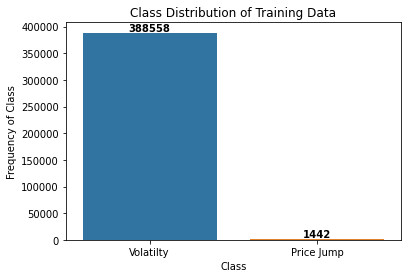


     Return  Sequence
0  0.709546         0
1 -0.102007         1
2 -0.013313         2
3  0.042152         3
4  0.152927         4
5  0.035428         5
6 -0.105214         6
7  0.313100         7
8 -0.083987         8
9 -0.080738         9
(390000, 2)

     Return  Sequence
0 -0.288097         0
1 -0.549686         1
2 -0.465252         2
3 -0.029156         3
4  0.639355         4
5  0.217032         5
6  0.245396         6
7  0.517974         7
8  0.100066         8
9  0.157492         9
(19500, 2)

   Sequence  Label
0         0      0
1         1      0
2         2      0
3         3      0
4         4      0
5         5      0
6         6      0
7         7      0
8         8      0
9         9      0
(19500, 2)


In [ ]:
# Reading in training and Combined data
train = pd.read_csv('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/Log_Training_Data_Distribution.csv',
                    index_col = 0)
train = pd.DataFrame(train)

test = pd.read_csv('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/Log_Test_Data_Distribution.csv',
                   index_col = 0)
test = pd.DataFrame(test)

SMOTE_Combined = pd.read_csv('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/SMOTE_Log_Training_Data.csv',
                             index_col = 0)
SMOTE_Combined = pd.DataFrame(SMOTE_Combined)

# Plotting Class Imbalance in Data

class_, frequency = np.unique(train.Label, return_counts=True)
labels_data = dict(zip(class_, frequency))
print('Frequency of Volatility:', labels_data[0])
print('Frequency of Jumps:', labels_data[1])
print()

neg, pos = labels_data[0], labels_data[1]
comb = labels_data[0] + labels_data[1]
pos_class, neg_class = pos / comb, neg / comb
pos_class, neg_class = round(pos_class * 100, 2), round(neg_class * 100, 2)

print('Positive Class %:', pos_class)
print('Negative Class %:', neg_class)

sns.barplot(list(labels_data.keys()), list(labels_data.values()))

plt.title('Class Distribution of Training Data')
plt.ylabel('Frequency of Class')

plt.xlabel('Class')
plt.xticks(ticks=class_, labels = ['Volatilty', 'Price Jump'])

for i, v in enumerate(frequency):
    plt.text(i, v, s=str(v), color='black',
             fontweight='bold', ha='center', va='bottom')
plt.show()

# Removing Time Column
train.drop(train.columns[-2], axis=1, inplace=True)

# Separating Labels 
y = train.Label

# Removing Label Column
train.drop(train.columns[-2], axis=1, inplace=True)
train = pd.DataFrame(train)

# Removing Time Column
test.drop(test.columns[-3], axis=1, inplace=True)
test = pd.DataFrame(test)

# Separating Labels & Removing Time & Return
ytest = pd.DataFrame(test)
ytest.drop(test.columns[-3], axis=1, inplace=True)
ytest = pd.DataFrame(ytest)

# Removing Label Column
test.drop(test.columns[-1], axis=1, inplace=True)
test = pd.DataFrame(test)

print()
print(train.head(n=10))
print(train.shape)
print()
print(test.head(n=10))
print(test.shape)
print()
print(ytest.head(n=10))
print(ytest.shape)

In [ ]:
np.random.seed(111)

x_train, x_valid, y_train, y_valid, = train_test_split(train, y,
    test_size=0.25, random_state=111)

print("Number transactions x_train dataset: ", x_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions x_test dataset: ", x_valid.shape) 
print("Number transactions y_test dataset: ", y_valid.shape) 
print()
print("Before SMOTE, counts of Price Jumps in Training Data: {}".format(sum(y_train == 1))) 
print("Before SMOTE, counts of Volatility in Training Data: {} \n".format(sum(y_train == 0))) 
print("Before SMOTE, total count in Training Data: {} \n".format(sum(y_train == 0) + sum(y_train == 1)))  

print("Before SMOTE, counts of Price Jumps in Validation Data: {}".format(sum(y_valid == 1))) 
print("Before SMOTE, counts of Volatility in Validation Data: {} \n".format(sum(y_valid == 0))) 
print("Before SMOTE, total count in Validation Data: {} \n".format(sum(y_valid == 0) + sum(y_valid == 1)))  


Number transactions x_train dataset:  (292500, 2)
Number transactions y_train dataset:  (292500,)
Number transactions x_test dataset:  (97500, 2)
Number transactions y_test dataset:  (97500,)

Before SMOTE, counts of Price Jumps in Training Data: 1085
Before SMOTE, counts of Volatility in Training Data: 291415 

Before SMOTE, total count in Training Data: 292500 

Before SMOTE, counts of Price Jumps in Validation Data: 357
Before SMOTE, counts of Volatility in Validation Data: 97143 

Before SMOTE, total count in Validation Data: 97500 



In [ ]:
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
x_train, y_train = pipeline.fit_resample(x_train, y_train)
x_valid, y_valid = pipeline.fit_resample(x_valid, y_valid)
print()

print('After SMOTE, the shape of x_train_1: {}'.format(x_train.shape)) 
print('After SMOTE, the shape of y_train_1: {} \n'.format(y_train.shape))
print('After SMOTE, the shape of x_valid_1: {}'.format(x_valid.shape)) 
print('After SMOTE, the shape of y_valid_1: {} \n'.format(y_valid.shape))
 
print("After SMOTE, counts of Price Jumps in Training Data: {}".format(sum(y_train == 1))) 
print("After SMOTE, counts of Volatility in Training Data: {}".format(sum(y_train == 0))) 
print("After SMOTE, total count in Training Data: {} \n".format(sum(y_train == 0) + sum(y_train == 1)))

print("After SMOTE, counts of Price Jumps in Validation Data: {}".format(sum(y_valid == 1))) 
print("After SMOTE, counts of Volatility in Validation Data: {}".format(sum(y_valid == 0))) 
print("After SMOTE, total count in Validation Data: {} \n".format(sum(y_valid == 0) + sum(y_valid == 1)))

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_valid = pd.DataFrame(x_valid)
y_valid = pd.DataFrame(y_valid)


After SMOTE, the shape of x_train_1: (87423, 2)
After SMOTE, the shape of y_train_1: (87423,) 

After SMOTE, the shape of x_valid_1: (29142, 2)
After SMOTE, the shape of y_valid_1: (29142,) 

After SMOTE, counts of Price Jumps in Training Data: 29141
After SMOTE, counts of Volatility in Training Data: 58282
After SMOTE, total count in Training Data: 87423 

After SMOTE, counts of Price Jumps in Validation Data: 9714
After SMOTE, counts of Volatility in Validation Data: 19428
After SMOTE, total count in Validation Data: 29142 



In [ ]:
# Reshaping data into 3d format for LSTM input

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test  = np.array(test)
y_test  = np.array(ytest)

n_samples_train = x_train.shape[0]
n_samples_valid = x_valid.shape[0]
n_samples_test =  x_test.shape[0]
n_timesteps = 2
n_timesteps_x =  x_train.shape[1]
n_timesteps_y =  y_train.shape[1]
n_timesteps_t =  x_test.shape[1]
n_timesteps_yt = y_test.shape[0]
n_features = 1

x_train = np.reshape(x_train, (n_samples_train, n_timesteps_x, n_features))
x_valid = np.reshape(x_valid, (n_samples_valid, n_timesteps_x, n_features))
y_train = np.reshape(y_train, (n_samples_train, n_timesteps_y, n_features))
y_valid = np.reshape(y_valid, (n_samples_valid, n_timesteps_y, n_features))
x_test =  np.reshape(x_test,  (n_samples_test,  n_timesteps_t, n_features))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

Frequency of Volatility: 77710
Frequency of Jumps: 38855

Positive Class %: 33.33
Negative Class %: 66.67


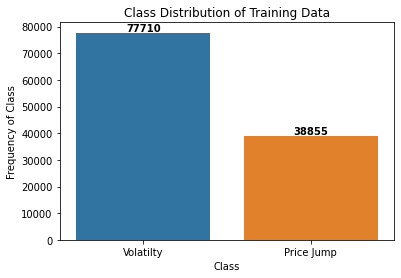

In [ ]:
# Plotting Class Imbalance after SMOTE

class_, frequency = np.unique(SMOTE_Combined.Label, return_counts=True)
labels_data = dict(zip(class_, frequency))
print('Frequency of Volatility:', labels_data[0])
print('Frequency of Jumps:', labels_data[1])
print()

neg, pos = labels_data[0], labels_data[1]
comb = labels_data[0] + labels_data[1]
pos_class, neg_class = pos / comb, neg / comb
pos_class, neg_class = round(pos_class * 100, 2), round(neg_class * 100, 2)

print('Positive Class %:', pos_class)
print('Negative Class %:', neg_class)

sns.barplot(list(labels_data.keys()), list(labels_data.values()))

plt.title('Class Distribution of Training Data')
plt.ylabel('Frequency of Class')

plt.xlabel('Class')
plt.xticks(ticks=class_, labels = ['Volatilty', 'Price Jump'])

for i, v in enumerate(frequency):
    plt.text(i, v, s=str(v), color='black',
             fontweight='bold', ha='center', va='bottom')
plt.show()

In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1 = Sequential()
ac_model_1.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1.add(LSTM(150))
ac_model_1.add(Dropout(0.2))

ac_model_1.add(RepeatVector(n_timesteps))

ac_model_1.add(LSTM(150, return_sequences = True))
ac_model_1.add(Dropout(0.2))
ac_model_1.add(LSTM(200, return_sequences = True))
ac_model_1.add(TimeDistributed(Dense(1, activation='sigmoid')))

ac_model_1.compile(loss='binary_crossentropy', optimizer='SGD', 
                 metrics=['accuracy'])

results_ac_model_1 = ac_model_1.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1.summary())

ac_model_1.save('lstm_model.h5')

Epoch 1/100
2732/2732 [==============================] - 91s 33ms/step - loss: 0.6391 - accuracy: 0.6666 - val_loss: 0.6349 - val_accuracy: 0.6667
Epoch 2/100
2732/2732 [==============================] - 91s 33ms/step - loss: 0.6340 - accuracy: 0.6667 - val_loss: 0.6331 - val_accuracy: 0.6667
Epoch 3/100
2732/2732 [==============================] - 94s 34ms/step - loss: 0.6317 - accuracy: 0.6667 - val_loss: 0.6304 - val_accuracy: 0.6667
Epoch 4/100
2732/2732 [==============================] - 93s 34ms/step - loss: 0.6285 - accuracy: 0.6667 - val_loss: 0.6274 - val_accuracy: 0.6667
Epoch 5/100
2732/2732 [==============================] - 94s 34ms/step - loss: 0.6253 - accuracy: 0.6667 - val_loss: 0.6252 - val_accuracy: 0.6667
Epoch 6/100
2732/2732 [==============================] - 95s 35ms/step - loss: 0.6231 - accuracy: 0.6667 - val_loss: 0.6231 - val_accuracy: 0.6671
Epoch 7/100
2732/2732 [==============================] - 94s 35ms/step - loss: 0.6216 - accuracy: 0.6750 - val_loss: 0

In [ ]:
# Performance Metrics
y_train = np.reshape(y_train, (n_samples_train, n_timesteps_y))
y_valid = np.reshape(y_valid, (n_samples_valid, n_timesteps_y))

y_pred_1 = ac_model_1.predict(x_train) 
y_pred_bool_1 = np.argmax(y_pred_1, axis=1)

train_acc = accuracy_score(y_train, y_pred_bool_1)
train_acc = train_acc * 100
train_acc = round(train_acc, 2)
train_prec = precision_score(y_train, y_pred_bool_1, average="binary")
train_prec = train_prec * 100
train_prec = round(train_prec, 2)
train_rec  = recall_score(y_train, y_pred_bool_1, average="binary")
train_rec  = train_rec * 100
train_rec  = round(train_rec, 2)
train_f1   = f1_score(y_train, y_pred_bool_1, average="binary")
train_f1   = train_f1 * 100

print('Training CM')
cm_1 = confusion_matrix(y_train, y_pred_bool_1)
print(cm_1)

y_pred_2 = ac_model_1.predict(x_valid) 
y_pred_bool_2 = np.argmax(y_pred_2, axis=1)

valid_acc = accuracy_score(y_valid, y_pred_bool_2)
valid_acc = valid_acc * 100
valid_acc = round(valid_acc, 2)
valid_prec = precision_score(y_valid, y_pred_bool_2, average="binary")
valid_prec = valid_prec * 100
valid_prec = round(valid_prec, 2)
valid_rec  = recall_score(y_valid, y_pred_bool_2, average="binary")
valid_rec  = valid_rec * 100
valid_rec  = round(valid_rec, 2)
valid_f1   = f1_score(y_valid, y_pred_bool_2, average="binary")
valid_f1   = valid_f1 * 100

print('Validation CM')
cm_2 = confusion_matrix(y_valid, y_pred_bool_2)
print(cm_2)

y_pred = ac_model_1.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_test = pd.DataFrame(y_test)
#y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

print('Test CM')
cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")
f1   = f1 * 100

print('Overall Training Accuracy:',    train_acc,  '%')
print('Overall Training Precision:',   train_prec, '%')
print('Overall Training Recall:',      train_rec,  '%')
print('Overall Training F1 Score:',    train_f1)
print()
print('Overall Validation Accuracy:',  valid_acc,  '%')
print('Overall Validation Precision:', valid_prec, '%')
print('Overall Validation Recall:',    valid_rec,  '%')
print('Overall Validation F1 Score:',  valid_f1)
print()
print('Overall Test Accuracy:',        acc,        '%')
print('Overall Test Precision:',       prec,       '%')
print('Overall Test Recall:',          rec,        '%')
print('Overall Test F1 Score:',        f1)

Training CM
[[58264    18]
 [    0 29141]]
Validation CM
[[19426     2]
 [  643  9071]]
Test CM
[[19491     1]
 [    0     8]]
Overall Training Accuracy: 99.98 %
Overall Training Precision: 99.94 %
Overall Training Recall: 100.0 %
Overall Training F1 Score: 99.96912521440824

Overall Validation Accuracy: 97.79 %
Overall Validation Precision: 99.98 %
Overall Validation Recall: 93.38 %
Overall Validation F1 Score: 96.56677489753552

Overall Test Accuracy: 99.9949 %
Overall Test Precision: 88.89 %
Overall Test Recall: 100.0 %
Overall Test F1 Score: 94.11764705882352


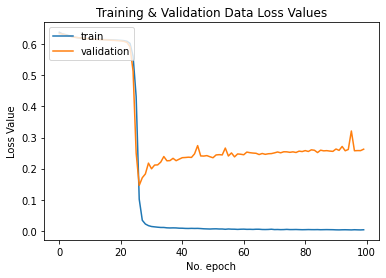

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1.history['loss'], label='train')
plt.plot(results_ac_model_1.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

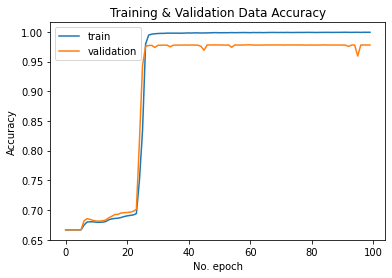

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1.history['accuracy'], label='train')
plt.plot(results_ac_model_1.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()